## HW8 - Josephine Junyun He
Please do the following in a jupyter notebook:
- Build a model with a lower average cross-validated RMSE than the best model that we saw in class (-0.008575141851714435) for prediction hourly returns for SOL
    - use 20% of the data set for validation in you cross-validation
    - make sure you're using a time-series dependent cross-validation method
    - you may use any transformation and model you would like
    - you will likely need to feature engineer to beat the class model

Tips:
- model training can sometimes be expensive, depending on the model - use the learning curve to help you understand how long it would take a model to train
- you will likely get the most yield by feature engineering
- hyperparameter tuning is a higher order optimization, it is useful to get the best result of your chosen model, however if your model is not performant it will rarely make it magically performant

In [1]:
data_location = 'sqlite:///../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [52]:
def obv(df):
    """Calculate On Balance Volume(obv) -> DataFrame """
    obv = np.where(df['close'] > df['close'].shift(1), df['volume'], np.where(df['close'] < df['close'].shift(1), -df['volume'], 0)).cumsum()
    print("shape of function", obv.shape)
    return obv

In [53]:
df = ohlc.copy()
df['obv'] = obv(df)
df

shape of function (11627,)


,ts,open,high,low,close,volume,volumeUSD,token,chain,obv
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC,0.000000e+00
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC,3.324812e+02
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC,1.823047e+01
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC,-1.041701e+03
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC,-1.663121e+03
...,...,...,...,...,...,...,...,...,...,...
11622,2021-12-14 20:00:00,178.99,181.27,178.72,180.28,628.699000,1.130815e+05,COMP,ETH,-9.767708e+07
11623,2021-12-14 21:00:00,180.15,183.76,179.96,183.43,2453.455000,4.447119e+05,COMP,ETH,-9.767463e+07
11624,2021-12-14 22:00:00,183.31,186.74,182.60,185.24,2086.017000,3.865710e+05,COMP,ETH,-9.767254e+07
11625,2021-12-14 23:00:00,185.22,186.09,183.88,185.08,416.028000,7.698720e+04,COMP,ETH,-9.767296e+07


In [5]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [6]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [7]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [8]:
ohlc['obv'] = np.where(ohlc['close'] > ohlc['close'].shift(1), ohlc['volume'], np.where(ohlc['close'] < ohlc['close'].shift(1), -ohlc['volume'], 0)).cumsum()
# ohlc['obv'] = obv(ohlc), not sure why using the function doesn't work, give an error

In [9]:
ohlc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11627 entries, 0 to 11626
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         11627 non-null  object 
 1   open       11627 non-null  float64
 2   high       11627 non-null  float64
 3   low        11627 non-null  float64
 4   close      11627 non-null  float64
 5   volume     11627 non-null  float64
 6   volumeUSD  11627 non-null  float64
 7   token      11627 non-null  object 
 8   chain      11627 non-null  object 
 9   obv        11627 non-null  float64
dtypes: float64(7), object(3)
memory usage: 908.5+ KB


In [10]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain,obv
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC,0.000000
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC,332.481185
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC,18.230465
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC,-1041.700893
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC,-1663.120771


In [11]:
tokens = ohlc.token.unique()

In [12]:
print("Total number of tokens: ",len(tokens))
tokens

Total number of tokens:  11


array(['BTC', 'ETH', 'USDT', 'SOL', 'ADA', 'DOT', 'AVAX', 'ATOM', 'CRV',
       'AAVE', 'COMP'], dtype=object)

In [13]:
ohlc.isnull().sum()

ts           0
open         0
high         0
low          0
close        0
volume       0
volumeUSD    0
token        0
chain        0
obv          0
dtype: int64

In [14]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            #daily=df.high/df.low - 1,
            ret=df.close.pct_change(),
        )[['ts', 'vol', 'obv', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'obv', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [15]:
X.head()

,vol_BTC,obv_BTC,ret_BTC,vol_ETH,obv_ETH,ret_ETH,vol_USDT,obv_USDT,ret_USDT,vol_SOL,...,ret_ATOM,vol_CRV,obv_CRV,ret_CRV,vol_AAVE,obv_AAVE,ret_AAVE,vol_COMP,obv_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,0.000000,NaN,0.0,-52533.162665,NaN,0.0,-2.067574e+06,NaN,0.0,...,NaN,0.0,-9.120466e+07,NaN,0.0,-9.752450e+07,NaN,0.0,-9.764136e+07,NaN
2021-11-01 01:00:00,0.0,332.481185,0.004357,0.0,-44343.393269,0.006874,0.0,-2.067574e+06,0.0000,0.0,...,0.008193,0.0,-9.095478e+07,0.000725,0.0,-9.752208e+07,0.008043,0.0,-9.764272e+07,-0.002281
2021-11-01 02:00:00,0.0,18.230465,-0.004508,0.0,-49209.872771,-0.005322,0.0,-4.448625e+06,-0.0002,0.0,...,-0.025419,0.0,-9.132790e+07,-0.031791,0.0,-9.752281e+07,-0.009171,0.0,-9.764550e+07,-0.006020
2021-11-01 03:00:00,0.0,-1041.700893,-0.012132,0.0,-62636.812900,-0.013126,0.0,-1.706685e+06,0.0001,0.0,...,-0.013943,0.0,-9.203443e+07,-0.010431,0.0,-9.752520e+07,-0.013301,0.0,-9.764911e+07,-0.022273
2021-11-01 04:00:00,0.0,-1663.120771,-0.010186,0.0,-71096.882919,-0.010679,0.0,-1.706685e+06,0.0000,0.0,...,-0.020046,0.0,-9.178427e+07,0.004514,0.0,-9.752685e+07,-0.016452,0.0,-9.765150e+07,-0.024002


In [16]:
X.shape

(1057, 33)

In [17]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [18]:
y.shape

(1056,)

In [19]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [20]:
X.shape

(1056, 33)

In [21]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

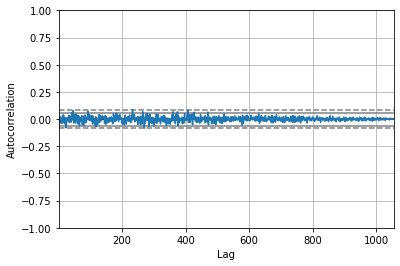

In [22]:
autocorrelation_plot(y[1:]);

In [23]:
X.head()

,vol_BTC,obv_BTC,ret_BTC,vol_ETH,obv_ETH,ret_ETH,vol_USDT,obv_USDT,ret_USDT,vol_SOL,...,ret_ATOM,vol_CRV,obv_CRV,ret_CRV,vol_AAVE,obv_AAVE,ret_AAVE,vol_COMP,obv_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,0.000000,NaN,0.0,-52533.162665,NaN,0.0,-2.067574e+06,NaN,0.0,...,NaN,0.0,-9.120466e+07,NaN,0.0,-9.752450e+07,NaN,0.0,-9.764136e+07,NaN
2021-11-01 01:00:00,0.0,332.481185,0.004357,0.0,-44343.393269,0.006874,0.0,-2.067574e+06,0.0000,0.0,...,0.008193,0.0,-9.095478e+07,0.000725,0.0,-9.752208e+07,0.008043,0.0,-9.764272e+07,-0.002281
2021-11-01 02:00:00,0.0,18.230465,-0.004508,0.0,-49209.872771,-0.005322,0.0,-4.448625e+06,-0.0002,0.0,...,-0.025419,0.0,-9.132790e+07,-0.031791,0.0,-9.752281e+07,-0.009171,0.0,-9.764550e+07,-0.006020
2021-11-01 03:00:00,0.0,-1041.700893,-0.012132,0.0,-62636.812900,-0.013126,0.0,-1.706685e+06,0.0001,0.0,...,-0.013943,0.0,-9.203443e+07,-0.010431,0.0,-9.752520e+07,-0.013301,0.0,-9.764911e+07,-0.022273
2021-11-01 04:00:00,0.0,-1663.120771,-0.010186,0.0,-71096.882919,-0.010679,0.0,-1.706685e+06,0.0000,0.0,...,-0.020046,0.0,-9.178427e+07,0.004514,0.0,-9.752685e+07,-0.016452,0.0,-9.765150e+07,-0.024002


In [24]:
X.fillna(0,inplace=True)

In [25]:
pd.isnull(X).sum()

vol_BTC     0
obv_BTC     0
ret_BTC     0
vol_ETH     0
obv_ETH     0
ret_ETH     0
vol_USDT    0
obv_USDT    0
ret_USDT    0
vol_SOL     0
obv_SOL     0
ret_SOL     0
vol_ADA     0
obv_ADA     0
ret_ADA     0
vol_DOT     0
obv_DOT     0
ret_DOT     0
vol_AVAX    0
obv_AVAX    0
ret_AVAX    0
vol_ATOM    0
obv_ATOM    0
ret_ATOM    0
vol_CRV     0
obv_CRV     0
ret_CRV     0
vol_AAVE    0
obv_AAVE    0
ret_AAVE    0
vol_COMP    0
obv_COMP    0
ret_COMP    0
dtype: int64

In [26]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.028693550573573322,
 'obv_BTC': 0.020195092827086553,
 'ret_BTC': -0.013750904628805061,
 'vol_ETH': 0.023571512894692854,
 'obv_ETH': 0.028599022261704108,
 'ret_ETH': 0.03059252304648374,
 'vol_USDT': 0.0068501801913109055,
 'obv_USDT': -0.025190403319913533,
 'ret_USDT': -0.04428727142792736,
 'vol_SOL': 0.03485259726638475,
 'obv_SOL': 0.009086584257505971,
 'ret_SOL': -0.029752016175605616,
 'vol_ADA': 0.03888023343700738,
 'obv_ADA': -0.012822762956863324,
 'ret_ADA': 0.0003265691221125249,
 'vol_DOT': 0.05904076845167186,
 'obv_DOT': 0.019627900834142134,
 'ret_DOT': 0.008242785834655122,
 'vol_AVAX': 0.041408511560781514,
 'obv_AVAX': -0.02851599071920401,
 'ret_AVAX': 0.016823801668886255,
 'vol_ATOM': -0.0022346077856851467,
 'obv_ATOM': -0.011208731314217155,
 'ret_ATOM': 0.055390678880821366,
 'vol_CRV': 0.019828890149893356,
 'obv_CRV': -0.0035167086706348093,
 'ret_CRV': -0.0058199869516400195,
 'vol_AAVE': 0.0360507780728068,
 'obv_AAVE': 0.0164707206284418

### Model

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [28]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [29]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [30]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['vol_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.011974798408384153

In [31]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['obv_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.013838747660195615

In [32]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.01287102367543804

In [33]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.013977971858555828

In [34]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=5)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008811322963537687

In [35]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components= 20)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008645440776522502

In [36]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.00865972248975801

### Hyperparameter Tuning

In [40]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 15, 20, 25, 30, 33],
    'model__alpha': [0.1, 0.5, 1.0, 10.0]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0, 10.0],
                         'pca__n_components': [1, 5, 10, 15, 20, 25, 30, 33]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [41]:
search.best_params_

{'model__alpha': 1.0, 'pca__n_components': 25}

In [42]:
best_model = search.best_estimator_

In [43]:
evaluate_model(best_model, X, y)

-0.008558134498989525

<module 'matplotlib.pyplot' from 'C:\\Users\\jhe\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

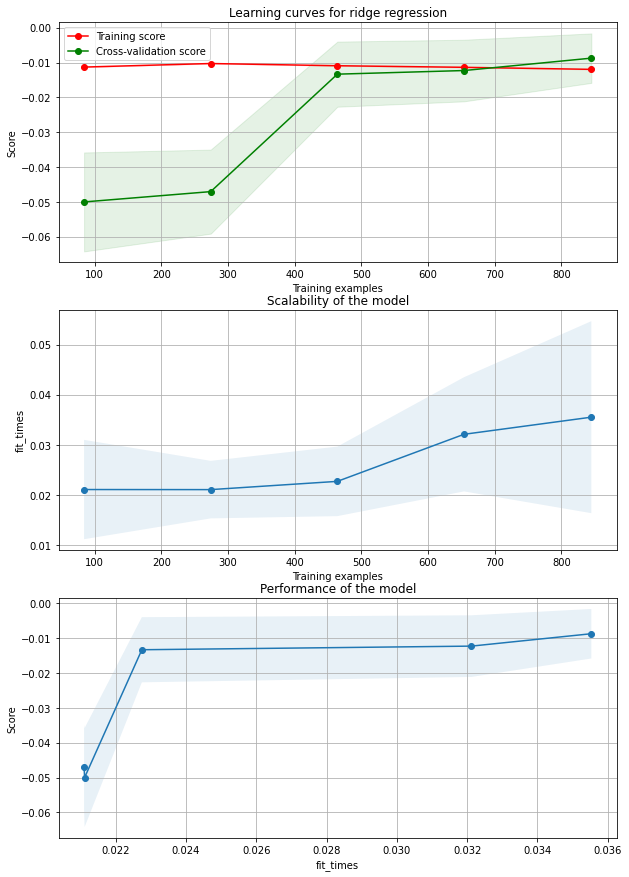

In [44]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)

In [45]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))

In [46]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [47]:
evaluate_model(best_model, X, y)

-0.008558134498989524

In [48]:
evaluate_model(loaded_model, X, y)

-0.008558134498989529